In [1]:
# Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split #serpara los datos 
from sklearn.metrics import confusion_matrix, classification_report #estos los regulatado las claisigfacion y la matriz de confusion
from sklearn.preprocessing import StandardScaler #normalizar los datos 


In [2]:
def to_classlabel(z):
    return z.argmax(axis = 1) #etiqeuta en la columna


In [3]:
#y susecion de numeros, 
def one_hot_encode(y):
    n_class = np.unique(y).shape[0] #cunatas clases tiene Y 
    y_encode = np.zeros((y.shape[0], n_class)) #inicialzia la tabla, rengloes(instancias ) columnas numero de clases
    for idx, val in enumerate(y):
        y_encode[idx, val] = 1.0
    return y_encode


In [4]:
# Define Accuracy
def accuracy(y_true, y_pred):
    acc = np.sum(y_true == y_pred) / len(y_true)
    return acc #presicion 



In [ ]:
class Logistic_Regression_GDX():
    
    def __init__(self, lambda_param=0.01):
        self.theta = None
        self.lambda_param = lambda_param  
        
    
    """modificacion
    def _sigmoid(self, A, theta ):
        # Linear model: yh = A * theta
        yh = np.dot(A, theta) #hipoetsis 
        # Sigmoid function 1 / (1 + e^(-yh))
        return 1/(1 + np.exp(-yh)) #funcion logistica 
    """

    def _sigmoid(self, A, theta):
        yh = np.dot(A, theta)
        # Añadir clip para estabilidad numérica
        yh = np.clip(yh, -500, 500)
        return 1/(1 + np.exp(-yh))



    def _loss(self, y, h):
        '''
        a really small value 'epsilon' is added to avoid 
        overflow and divison by zero error for log
        loss = (-1/q) * sum(y * log(h) + (1-y) * log(1 - h))
        where h = 1/(1 + e^(-yh))
        '''
        #el epsislon funciona por si la hipotrsis nos da 0 (log -> logaritmo natural )
        epsilon = 1e-5
        # modificacion 
        h = np.clip(h, epsilon, 1 - epsilon)
    
        reg_term = (self.lambda_param/(2*len(y))) * np.sum(self.theta[1:]**2)
        los = (-1/len(y)) * np.sum(y * np.log(h + epsilon) + (1-y) * np.log(1-h+epsilon)) + reg_term
        return los

    def fit(self, A, y, learning_rate=0.01, momentum=0.9, 
        lr_dec=0.5, lr_inc=1.05, max_perf_inc=1.04,
        epochs=100, batch_size=32, show_step=10, 
        stopping_threshold=1e-6, verbose=False):

        self.theta = np.random.randn(A.shape[1]) * 0.01
        n_obs = A.shape[0]
        batch_loss = []
        epoch_loss = []
        # self.theta = np.zeros(A.shape[1])
        delta_theta = np.zeros_like(self.theta)
        lr = learning_rate
        previous_loss = np.inf

        for e in range(epochs+1):
            THETA_prev = self.theta.copy()
            loss_e = 0
        
            indices = np.random.permutation(n_obs)
            A_shuffled = A[indices]
            y_shuffled = y[indices]

            
            n_batches = n_obs // batch_size
            residual = n_obs % batch_size
            total_batches = n_batches + (1 if residual != 0 else 0)
        
            for batch_idx in range(total_batches):
    
                start = batch_idx * batch_size
                end = start + batch_size
                if batch_idx == n_batches and residual != 0:
                    end = start + residual
                
                A_batch = A_shuffled[start:end]
                y_batch = y_shuffled[start:end]


                if fit_params['batch_size'] == len(y_train):  # Solo para batch completo
                    dropout_mask = np.random.binomial(1, 0.7, size=A_batch.shape)
                    A_batch = A_batch * dropout_mask
            
                y_pred = self._sigmoid(A_batch, self.theta)
                loss = self._loss(y_batch, y_pred)
                loss_e += loss
                batch_loss.append(loss)
            
         
                grad = (1/len(A_batch)) * np.dot(y_pred - y_batch, A_batch)
                grad[1:] += (self.lambda_param/len(A_batch)) * self.theta[1:]
                delta_theta = momentum * delta_theta - (1 - momentum) * lr * grad
                self.theta += delta_theta
        
            if loss_e > previous_loss * max_perf_inc:
                self.theta = THETA_prev
                lr *= lr_dec
            elif loss_e < previous_loss:
                lr *= lr_inc
            
            epoch_loss.append(loss_e)
        
            if abs(previous_loss - loss_e) < stopping_threshold:
                if verbose:
                    print(f"Early stopping at epoch {e}")
                break
            
            previous_loss = loss_e
        
            if verbose and e % show_step == 0:
                print(f'Epoch: {e}, loss: {loss_e:.3e}, lr: {lr:.2e}')
            
        return self.theta, batch_loss, epoch_loss
                
    def predict(self, A, threshold):
        y_predicted = self._sigmoid(A, self.theta)  #make prediction
        # Assign prediction to a class: 
        # if pred >= threshold then 1 else 0 and return as an array
        y_predicted_cls = [1 if i >= threshold else 0 for i in y_predicted]
        return np.array(y_predicted_cls)

In [6]:
# # Read the data
# data = np.loadtxt('admisiones_dataset.txt',delimiter=',')
# inputs = data[:,0:2]
# idx = 2-data[:,2] #restamos el 1 para establecer el categorico, adminitivos - 1 no admitivos - 0 
# targets = np.array(idx, dtype=int)     # codificacion categorica
# # targets = one_hot_encode(labels)      # one hot encode to classlabel


# Leer datos desde archivo cancer.dat
try:
    # Intenta leer como archivo de texto
    data = np.loadtxt('cancer_dataset.dat', delimiter=',')
except:
    # Intenta leer como binario si falla
    data = np.fromfile('cancer_dataset.dat', dtype=np.float32)
    data = data.reshape((-1, 31))  # Ajustar según la estructura de tus datos

# Procesamiento de datos
inputs = data[:, :-1]
targets = data[:, -1].astype(int)



In [7]:

# Split the data
# x_train,x_test,y_train,y_test = train_test_split(inputs,targets,test_size=0.40,random_state=1234) # test_size genreta entrenamiento y prueba 

# División de datos
x_train, x_test, y_train, y_test = train_test_split(
    inputs, targets, test_size=0.3, random_state=42
)

In [8]:
# Normalización
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [9]:

#matrices de disenio, 
A_train = np.c_[np.ones(len(x_train)), x_train]
A_test  = np.c_[np.ones(len(x_test)), x_test]

In [10]:

# Parámetros para el constructor

#minilot4es
# lambda_param = 0.1  # Regularización L2
# fit_params = {
#     'learning_rate': 0.01,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 64,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


#online
# lambda_param = 0.1  # Regularización L2
# fit_params = {
#     'learning_rate': 0.01,
#     'momentum': 0.95,
#     'lr_dec': 0.5,
#     'lr_inc': 1.05,
#     'max_perf_inc': 1.04,
#     'epochs': 1000,
#     'batch_size': 1,
#     'show_step': 100,
#     'stopping_threshold': 1e-6,
#     'verbose': True
# }


#online
lambda_param = 0.1  
fit_params = {
    'learning_rate': 0.1,
    'momentum': 0.95,
    'lr_dec': 0.5,
    'lr_inc': 1.05,
    'max_perf_inc': 1.04,
    'epochs': 300,
    'batch_size': len(y_train),
    'show_step': 50,
    'stopping_threshold': 1e-4,
    'verbose': True
}

In [11]:

# # Build and fit best LR model
# alpha = 0.01 #lr
# maxEpochs = 5000
# batch = 10 #minilotes
# show = 500 #view

# # Build model
# log_model = Logistic_Regression()
# # Fit Model
# theta, batch_loss, epoch_loss = log_model.fit(A_train, y_train, learning_rate=alpha, 
#                                 epochs=maxEpochs, batch_size=batch, show_step = show, verbose=True)


# Entrenamiento del modelo
model = Logistic_Regression_GDX(lambda_param=lambda_param)  # lambda_param aquí
theta, batch_loss, epoch_loss = model.fit(A_train, y_train, **fit_params)  # sin lambda_param aquí

Epoch: 0, loss: 6.937e-01, LR: 1.05e-01
Early stopping at epoch 33


In [12]:

# Predicciones y evaluación
train_pred = model.predict(A_train, 0.5)
test_pred = model.predict(A_test, 0.5)

In [14]:
# # Calculate accuracy
# train_acc = accuracy(y_train, train_pred)
# print(f'Accuracy on training set: {train_acc}')
#resultados finales
print(f'Accuracy: {accuracy(y_train, train_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_train, train_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_train, train_pred))


Accuracy: 0.9796

matriz de confusion:
[[318  10]
 [  0 161]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       328
           1       0.94      1.00      0.97       161

    accuracy                           0.98       489
   macro avg       0.97      0.98      0.98       489
weighted avg       0.98      0.98      0.98       489



In [15]:


# Calculate metrics - son de entrenamiento 
# cm_train = confusion_matrix(y_train, train_pred)
# train_report = classification_report(y_train, train_pred)

# print("Performance on training set:\n")
# print(f'Confusion Matrix:\n {cm_train}\n')
# print(f'Classification Report:\n {train_report}')

print(f'Accuracy: {accuracy(y_test, test_pred):.4f}')
print("\nmatriz de confusion:")
print(confusion_matrix(y_test, test_pred))
print("\nreporte de clasificacion:")
print(classification_report(y_test, test_pred))


Accuracy: 0.9810

matriz de confusion:
[[127   3]
 [  1  79]]

reporte de clasificacion:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       130
           1       0.96      0.99      0.98        80

    accuracy                           0.98       210
   macro avg       0.98      0.98      0.98       210
weighted avg       0.98      0.98      0.98       210



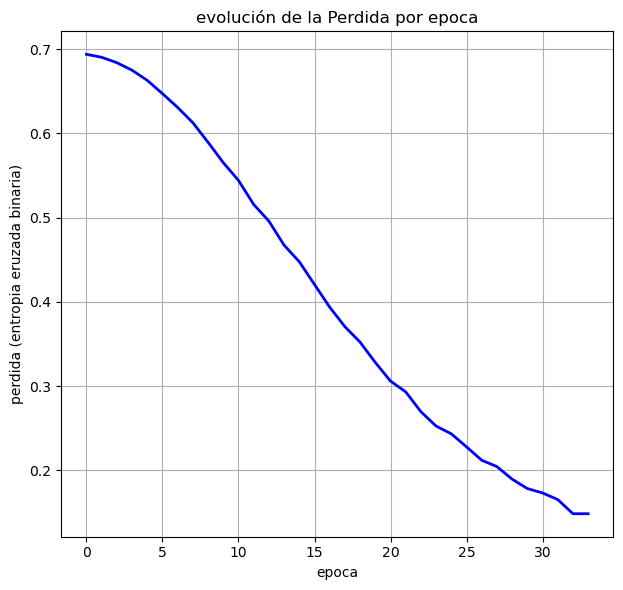

In [16]:
# Gráfica de pérdida
# Gráfica de pérdida
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_loss, 'b-', linewidth=2)
plt.title('evolución de la Perdida por epoca')
plt.xlabel('epoca')
plt.ylabel('perdida (entropia eruzada binaria)')
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_evolution.png', dpi=300)
plt.show()
